# K-Means vs LDA Topic Modelling Comparison

## Data pre-processing

In [60]:
import string

import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# For the usage of the following code can use nearly any Dataset you want.
# In this example the author used the Topic Modeling for Research Articles Dataset Licenced under DbCL v1.0 and created by Abishek Sudarshan
# The Dateset and Download Link can be found under https://www.kaggle.com/datasets/blessondensil294/topic-modeling-for-research-articles.

# Read the data (make sure to set the correct path and column)
df = pd.read_csv("./train.csv")
df_abstract = df['ABSTRACT']

# Remove rows with empty values in "abstract" column
df.dropna(subset=['ABSTRACT'], inplace=True)

# Word count before preprocessing
word_count_before = df['ABSTRACT'].apply(lambda x: len(word_tokenize(x))).sum()
# Print head before
print("Data before:")
print(df_abstract.head())

# Print word count before preprocessing
print("Word Count Before Preprocessing:", word_count_before)

# Text preprocessing

# Stopwords
stop_words = set(stopwords.words('english'))

# Translator
translator = str.maketrans('', '', string.punctuation)

# Lemmatizer + Stop Word + Greater than 3 char.
lemmatizer = WordNetLemmatizer()
df_abstract = df['ABSTRACT'].apply(lambda x: x.lower())  # Convert to lowercase
df_abstract = df_abstract.apply(lambda x: x.translate(translator))  # Remove punctuation
df_abstract = df_abstract.apply(lambda x: word_tokenize(x))  # Tokenization
df_abstract = df_abstract.apply(lambda x: [lemmatizer.lemmatize(word_stop) for word_stop in x if
                                           word_stop not in stop_words and len(
                                               word_stop) > 3])  # Lemmatization and remove stop words

# Create word frequency dictionary
word_freq = {}
for abstract in df_abstract:
    for word in abstract:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

# Define minimum number of words
min_word_count = 200

# Remove words that appear in less than 20 articles and more than 10% of the articles
min_article_count = 20
max_article_ratio = 0.1
df_abstract = df_abstract.apply(lambda x: [word_article for word_article in x if min_article_count <=
                                           word_freq[word_article] <= len(df_abstract) * max_article_ratio])

# Word count after preprocessing
word_count_after = df_abstract.apply(len).sum()

print("\n")
# Print head after
print("Data after:")
print(df_abstract.head())
# Print word count after preprocessing and word loss percentage
print("Word Count After Preprocessing:", word_count_after)
print("\n")
print("Word Loss Percentage:")
print(round((word_count_before - word_count_after) / word_count_before * 100, 3), "%")


Data before:
0      Predictive models allow subject-specific inf...
1      Rotation invariance and translation invarian...
2      We introduce and develop the notion of spher...
3      The stochastic Landau--Lifshitz--Gilbert (LL...
4      Fourier-transform infra-red (FTIR) spectra o...
Name: ABSTRACT, dtype: object
Word Count Before Preprocessing: 3620777


Data after:
0    [predictive, allow, inference, analyzing, dise...
1    [rotation, invariance, translation, invariance...
2    [introduce, develop, notion, spherical, natura...
3    [stochastic, coupled, maxwell, called, stochas...
4    [infrared, spectrum, plant, specie, explore, i...
Name: ABSTRACT, dtype: object
Word Count After Preprocessing: 1219352


Word Loss Percentage:
66.323 %


## K-means Clustering

### Creating k-means cluster

In [61]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert preprocessed text to TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_abstract.apply(lambda x: ' '.join(x)))

# Apply k-means clustering
k = 6  # Define the number of clusters
kmeans = KMeans(n_clusters=k, n_init=10).fit(tfidf_matrix)

# Get the cluster labels
cluster_labels = kmeans.labels_

### Display Top 10 Words of the k-means cluster

In [62]:
# Create a dictionary to store cluster words and frequencies
cluster_words = {}
cluster_word_freq = {}

# Iterate over documents and cluster labels
for doc_idx, label in enumerate(cluster_labels):
    document_words = df_abstract[doc_idx]  # Get the words of the document
    if label not in cluster_words:
        cluster_words[label] = set(document_words)  # Initialize the cluster's word set
    else:
        cluster_words[label].update(document_words)  # Add words to the cluster's word set

    # Update word frequencies for each cluster
    for word in document_words:
        if label not in cluster_word_freq:
            cluster_word_freq[label] = {word: 1}
        else:
            if word in cluster_word_freq[label]:
                cluster_word_freq[label][word] += 1
            else:
                cluster_word_freq[label][word] = 1

# Sort words in each cluster based on frequency
for label in cluster_words:
    sorted_words = sorted(cluster_words[label], key=cluster_word_freq[label].get,
                          reverse=True)  # Sort words by frequency
    cluster_words[label] = sorted_words

# Display top 10 words for each cluster in order
for label, words in sorted(cluster_words.items()):
    print(f"Cluster {label + 1}:")
    print(words[:10])
    print()


Cluster 1:
['quantum', 'magnetic', 'temperature', 'transition', 'spin', 'surface', 'material', 'electron', 'wave', 'particle']

Cluster 2:
['estimator', 'optimization', 'stochastic', 'estimation', 'random', 'error', 'variable', 'convergence', 'estimate', 'gradient']

Cluster 3:
['galaxy', 'star', 'mass', 'planet', 'stellar', 'cluster', 'observation', 'emission', 'formation', 'disk']

Cluster 4:
['classification', 'machine', 'datasets', 'dataset', 'object', 'prediction', 'accuracy', 'architecture', 'stateoftheart', 'classifier']

Cluster 5:
['algebra', 'finite', 'give', 'operator', 'polynomial', 'theorem', 'form', 'manifold', 'proof', 'dimension']

Cluster 6:
['user', 'design', 'social', 'agent', 'research', 'code', 'strategy', 'power', 'node', 'environment']



### Display Top 50 Words in the Cluster as Wordclouds

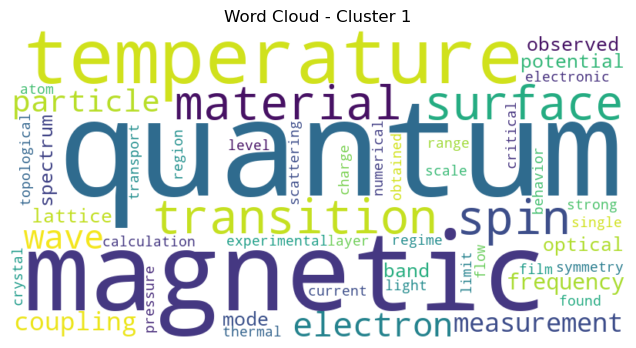

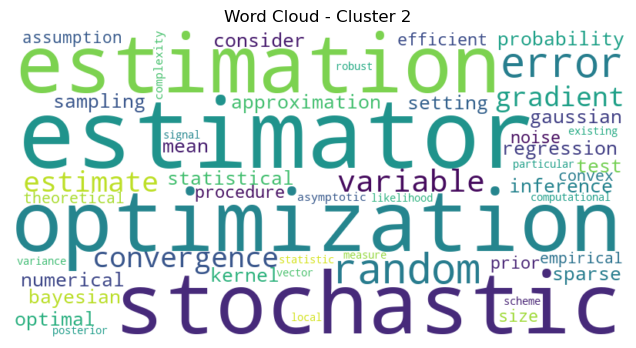

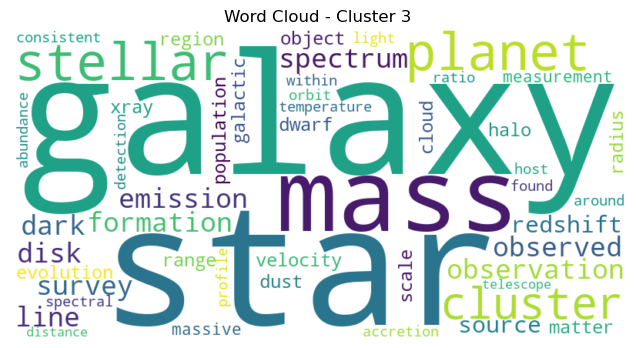

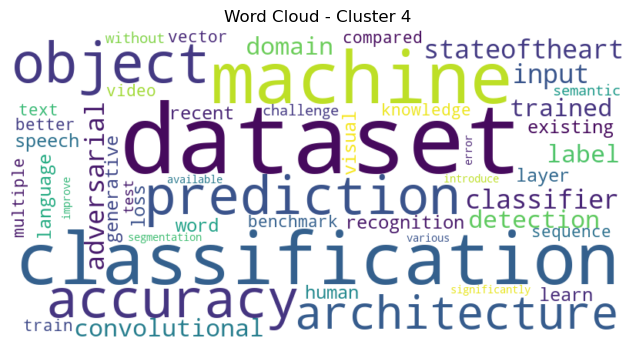

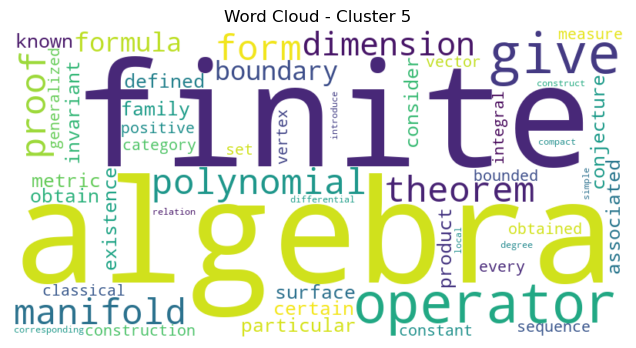

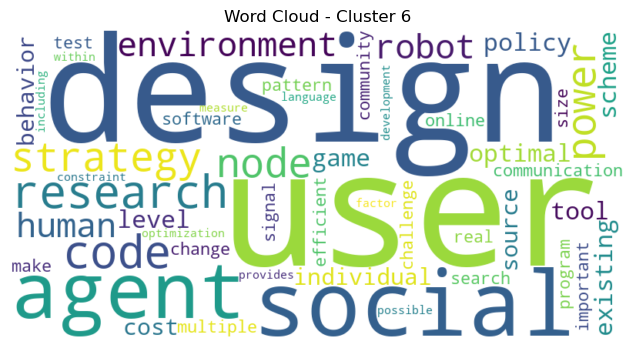

In [63]:
# Display top 50 words for each cluster in order and as word clouds
for label, words in sorted(cluster_words.items()):
    # Generate word cloud for the current cluster
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(words[:50]))

    # Display the word cloud
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud - Cluster {label + 1}")
    plt.show()


### Check the Cluster for a specific Document:

In [64]:
document_index = 1

print(f"Document {document_index} Title:")
print(df.loc[document_index, 'TITLE'], "\n")
print(f"Document {document_index} Abstract:")
print(df.loc[document_index, 'ABSTRACT'], "\n")
print(f"Document {document_index} belongs to Cluster {cluster_labels[document_index]}")

Document 1 Title:
Rotation Invariance Neural Network 

Document 1 Abstract:
  Rotation invariance and translation invariance have great values in image
recognition tasks. In this paper, we bring a new architecture in convolutional
neural network (CNN) named cyclic convolutional layer to achieve rotation
invariance in 2-D symbol recognition. We can also get the position and
orientation of the 2-D symbol by the network to achieve detection purpose for
multiple non-overlap target. Last but not least, this architecture can achieve
one-shot learning in some cases using those invariance.
 

Document 1 belongs to Cluster 3


### Check the found Document for three similar Documents

In [65]:
from sklearn.metrics.pairwise import cosine_similarity

# Get the cluster label for the document of interest
document_cluster_label = cluster_labels[document_index]

# Find the indices of all documents in the same cluster
similar_documents_indices = [i for i, label in enumerate(cluster_labels) if label == document_cluster_label]

similarity_scores = []
# Calculate the cosine similarity between the document of interest and all other documents in the same cluster
for index in similar_documents_indices:
    similarity_score = cosine_similarity(tfidf_matrix[document_index], tfidf_matrix[index])
    similarity_scores.append(similarity_score)

# Sort the documents in the same cluster by their similarity to the document of interest
similar_documents_sorted = [index for _, index in sorted(zip(similarity_scores, similar_documents_indices), reverse=True)]

# Get the top 3 similar document indices
similar_documents_lda = similar_documents_sorted[1:4]

# Print the titles of the top 3 similar documents
for index in similar_documents_lda:
    print(f"Document {index} Title:")
    print(df.loc[index, 'TITLE'], "\n")

Document 13060 Title:
Parametrizing filters of a CNN with a GAN 

Document 14917 Title:
How ConvNets model Non-linear Transformations 

Document 3147 Title:
Deep Neural Network Architectures for Modulation Classification 



## LDA Topic Modelling

### Create the LDA Model

In [66]:
import gensim
import gensim.corpora as corpora

# Prepare data
df_list = df_abstract.values.tolist()

# Create dictionary and corpus
id2word = corpora.Dictionary(df_list)
corpus = [id2word.doc2bow(text) for text in df_list]

# Fit LDA model
topics = 6
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=topics,
                                            random_state=100)

### Display Top 10 Words of the LDA Model

In [67]:
# Display top 10 words for each topic in order
for topic_id, topic_terms in lda_model.show_topics(num_words=10, formatted=False):
    words = [term[0] for term in topic_terms]
    print(f"Topic {topic_id + 1}:")
    print(words)
    print()

Topic 1:
['classification', 'prediction', 'test', 'machine', 'datasets', 'inference', 'object', 'dataset', 'accuracy', 'input']

Topic 2:
['magnetic', 'temperature', 'mass', 'transition', 'measurement', 'star', 'observed', 'spectrum', 'galaxy', 'surface']

Topic 3:
['quantum', 'operator', 'boundary', 'form', 'random', 'nonlinear', 'consider', 'limit', 'surface', 'numerical']

Topic 4:
['optimization', 'gradient', 'design', 'stochastic', 'optimal', 'node', 'scheme', 'attack', 'convergence', 'efficient']

Topic 5:
['estimator', 'algebra', 'give', 'estimation', 'finite', 'vector', 'complexity', 'consider', 'polynomial', 'vertex']

Topic 6:
['user', 'robot', 'social', 'research', 'environment', 'agent', 'game', 'human', 'community', 'design']



### Display Top 50 Words in the Topics as Wordclouds

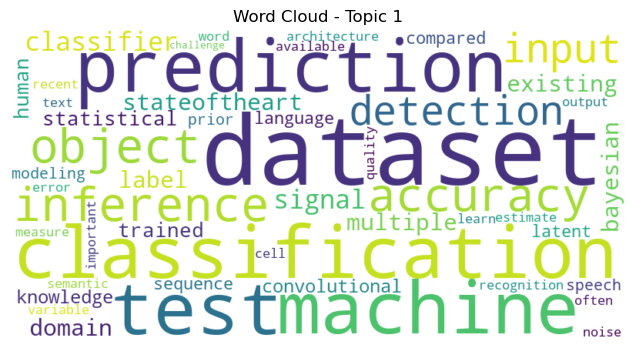

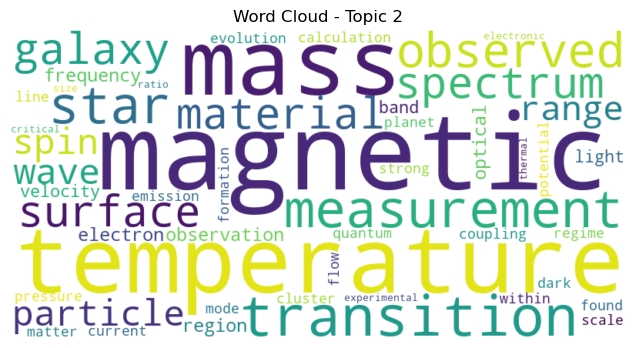

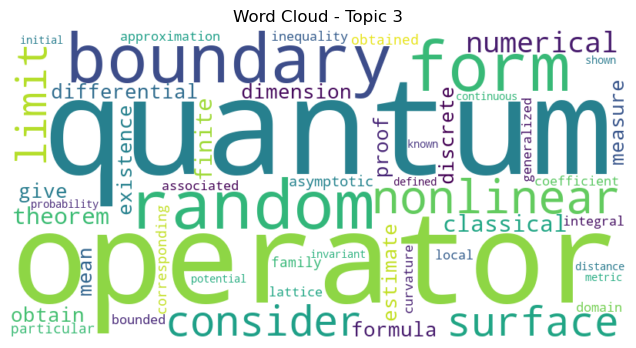

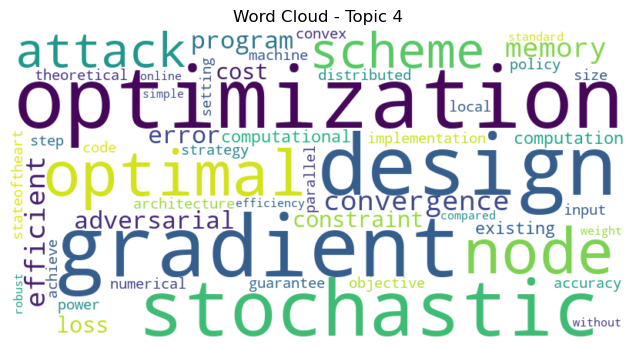

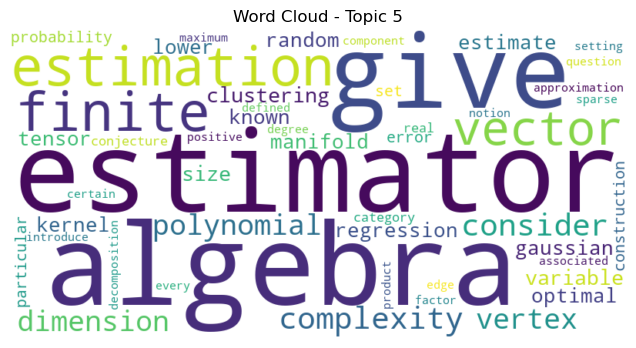

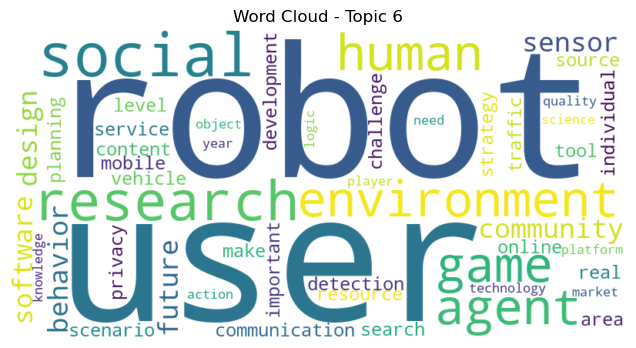

In [68]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Display top 50 words for each topic in order and as word clouds
for topic_id, topic_terms in lda_model.show_topics(num_words=50, formatted=False):
    # Extract the words from the topic terms
    words = [term[0] for term in topic_terms]

    # Generate word cloud for the current topic
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(words))

    # Display the word cloud
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud - Topic {topic_id + 1}")
    plt.show()

### Check the Cluster for a specific Document:

In [69]:
document_index = 1

# Get the document's topic distribution
document_topics = lda_model[corpus[document_index]]

# Display document details
print(f"Document {document_index} Title:")
print(df.loc[document_index, 'TITLE'], "\n")
print(f"Document {document_index} Abstract:")
print(df.loc[document_index, 'ABSTRACT'], "\n")

# Display the document's topic distribution and percentage
print(f"Document {document_index} Topic Distribution:")
for topic_id, topic_prob in document_topics:
    print(f"Topic {topic_id + 1}: {topic_prob:.2f} probability")

Document 1 Title:
Rotation Invariance Neural Network 

Document 1 Abstract:
  Rotation invariance and translation invariance have great values in image
recognition tasks. In this paper, we bring a new architecture in convolutional
neural network (CNN) named cyclic convolutional layer to achieve rotation
invariance in 2-D symbol recognition. We can also get the position and
orientation of the 2-D symbol by the network to achieve detection purpose for
multiple non-overlap target. Last but not least, this architecture can achieve
one-shot learning in some cases using those invariance.
 

Document 1 Topic Distribution:
Topic 1: 0.69 probability
Topic 3: 0.19 probability
Topic 5: 0.11 probability


### Check the Document for three similar Documents

In [70]:
from gensim.similarities import MatrixSimilarity

# Compute similarities between the document of interest and all other documents using the LDA model
docCorpus = corpus[document_index]
index = MatrixSimilarity(lda_model[corpus])
similar_documents_lda = index[lda_model[docCorpus]]

# Sort the similarities and select the top 3 most similar documents
similar_documents_lda = sorted(enumerate(similar_documents_lda), key=lambda item: -item[1])
top3 = similar_documents_lda[1:4]

# Print the titles and similarity scores of the top 3 most similar documents
for doc_position, doc_score in top3:
    print(f"Document {doc_position} Title:")
    print(df.loc[doc_position, 'TITLE'])
    print("Simlarity Score:", {doc_score})

Document 12172 Title:
Unsupervised learning of object frames by dense equivariant image labelling
Simlarity Score: {0.999811}
Document 3739 Title:
A time series distance measure for efficient clustering of input output signals by their underlying dynamics
Simlarity Score: {0.9990156}
Document 18589 Title:
Bayesian hypothesis tests with diffuse priors: Can we have our cake and eat it too?
Simlarity Score: {0.99853987}
